In [55]:
# Open image in openCv
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

### 6. Feature Matching
* Brute- Force Matching ORB
* Brute-Force Matching SIFT
* FLANN base Matcher


In [56]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')


In [57]:
reese = cv2.imread('DATA/reeses_puffs.png',0)

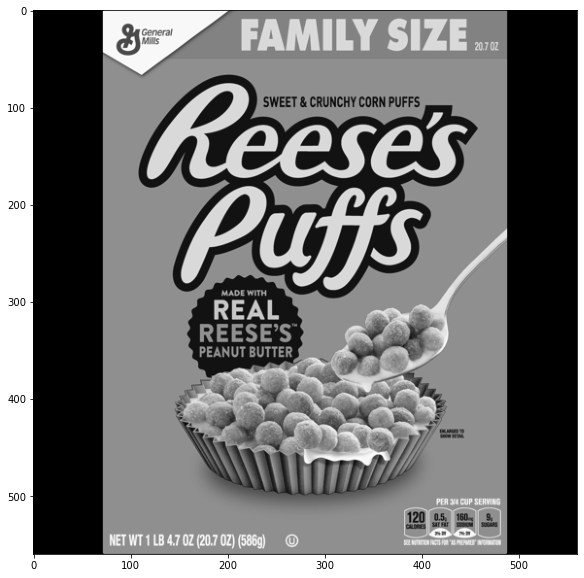

In [58]:
display(reese)

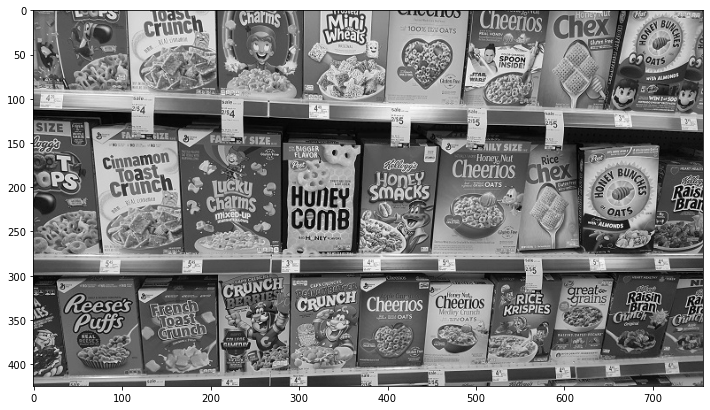

In [59]:
cereals = cv2.imread('DATA/many_cereals.jpg',0)
display(cereals)

In [60]:
orb = cv2.ORB_create()
kp1,des1 = orb.detectAndCompute(reese,None)
kp2,des2 = orb.detectAndCompute(cereals,None)

In [61]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches,key = lambda x:x.distance)

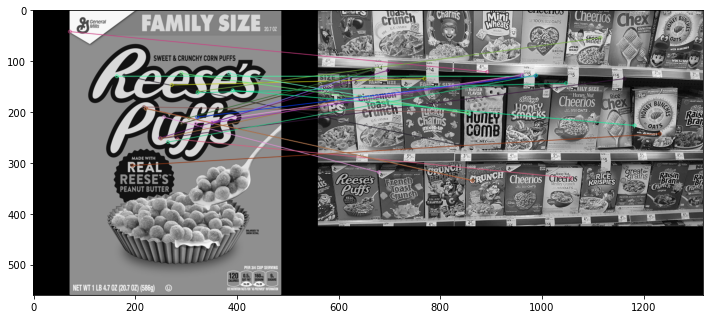

In [62]:
reese_matches = cv2.drawMatches(reese,kp1,cereals,kp2,matches[:25],None,flags=2)
display(reese_matches)

In [63]:
sift = cv2.xfeatures2d.SIFT_create()
kp1,des1 = sift.detectAndCompute(reese,None)
kp2,des2 = sift.detectAndCompute(cereals,None)

In [64]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

In [65]:
good = []
for match1,match2 in matches:
    if match1.distance < 0.75*match2.distance:
        good.append([match1])
len(good) ,len(matches)

(79, 1501)

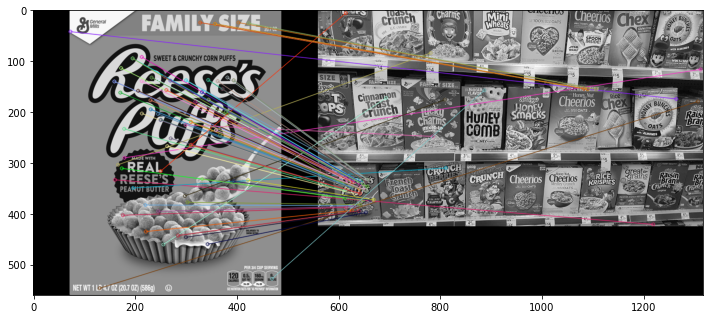

In [66]:
sift_matches = cv2.drawMatchesKnn(reese,kp1,cereals,kp2,good,None,flags=2)
display(sift_matches)

In [67]:
sift = cv2.xfeatures2d.SIFT_create()
kp1,des1 = sift.detectAndCompute(reese,None)
kp2,des2 = sift.detectAndCompute(cereals,None)

In [68]:
# FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
search_params = dict(checks=50)

In [69]:
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [70]:
matchesMask = [[0,0] for i in range(len(matches))]

In [71]:
for i,(match1,match2) in enumerate(matches):
    if match1.distance < 0.7*match2.distance:
        matchesMask[i] = [1,0]

In [72]:
draw_prams = dict(matchColor=(0,255,0),singlePointColor=(255,0,0),matchesMask=matchesMask,flags = 0)

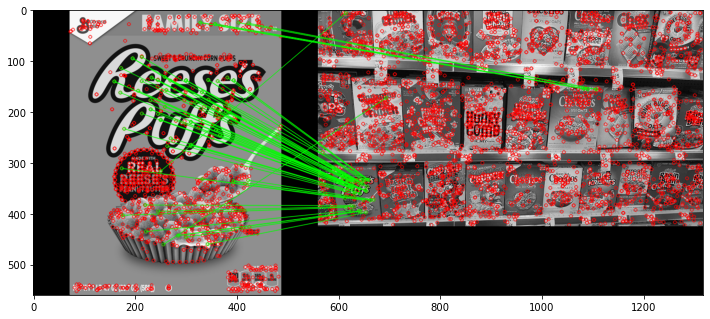

In [73]:
flann_matches = cv2.drawMatchesKnn(reese,kp1,cereals,kp2,matches,None,**draw_prams)
display(flann_matches)

### 7. Watershed Algorithm
* Use to segment image
* Change image to binary and find the border beetween heavy and light color

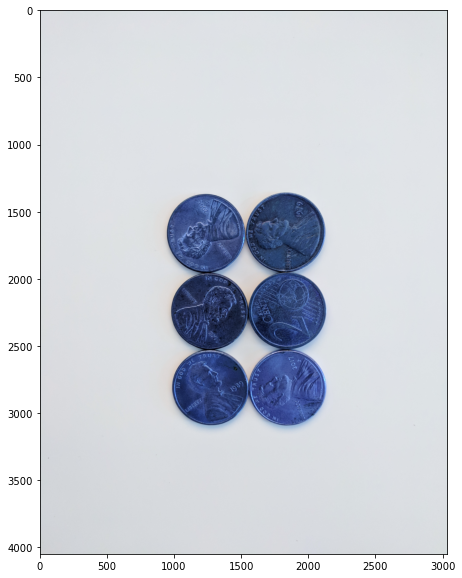

In [74]:
sep_coin = cv2.imread('DATA/pennies.jpg')
display(sep_coin)

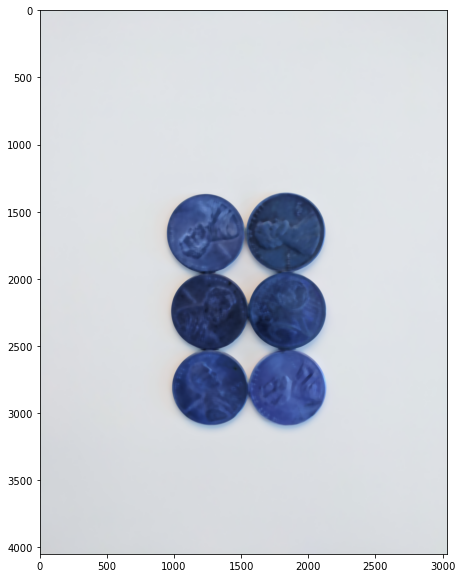

In [75]:
#mesina blur
sep_blur = cv2.medianBlur(sep_coin,25)
display(sep_blur)

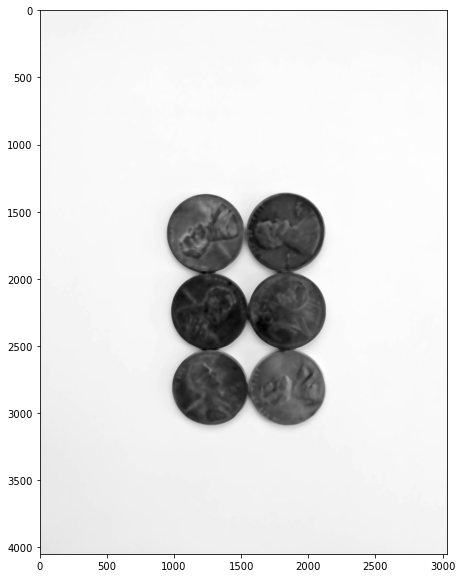

In [76]:
gray_sep_coins = cv2.cvtColor(sep_blur,cv2.COLOR_BGR2GRAY)
display(gray_sep_coins)

* Perform binary threshold

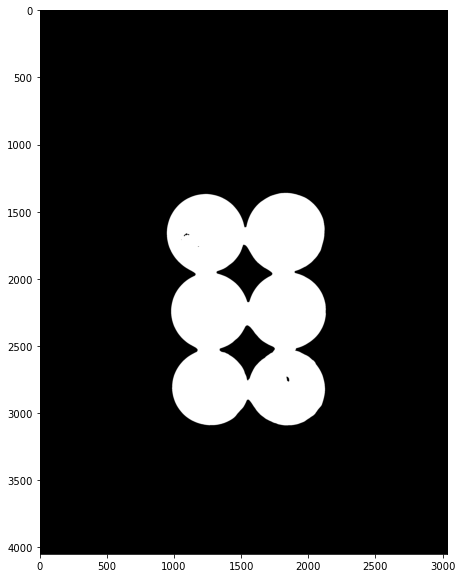

In [77]:
ret,sep_thresh = cv2.threshold(gray_sep_coins,150,255,cv2.THRESH_BINARY_INV)
display(sep_thresh)

In [78]:
contours,hierarchy = cv2.findContours(sep_thresh.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

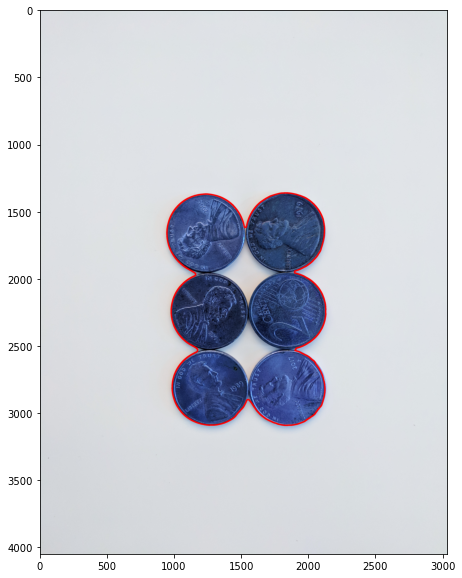

In [79]:
# find contuor
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coin,contours,i,(255,0,0),10)
display(sep_coin)

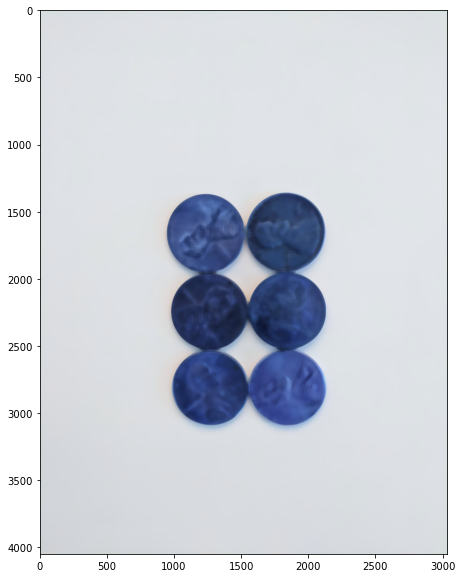

In [80]:
img = cv2.imread('DATA/pennies.jpg')
img = cv2.medianBlur(img,35)
display(img)

* Change image to grayscale, because it is binary so effect is not clear, but the watershed work better in grayscale image

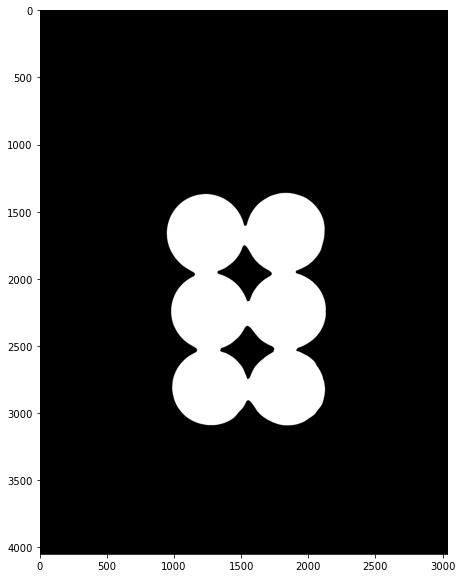

In [81]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
display(thresh)

* Dilate the contour and egde by morphologyEx
* If color is white -> tacke white, else black

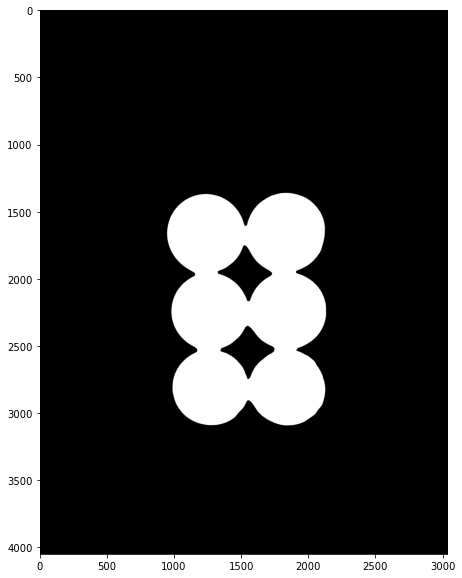

In [82]:
kernel = np.ones((3,2),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)
display(opening)

* find surely background

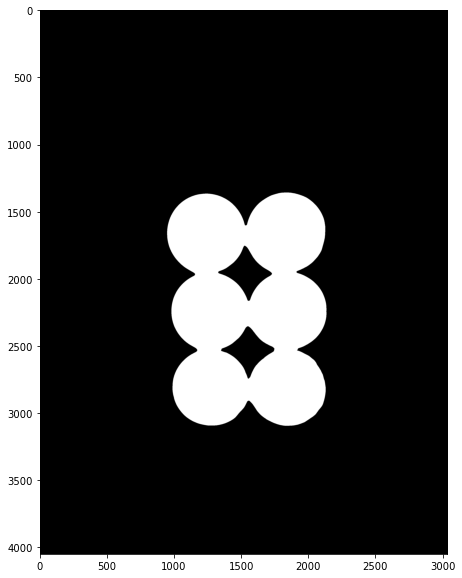

In [83]:
sure_bg = cv2.dilate(opening,kernel,iterations=3)
display(sure_bg,cmap='gray')

* find picture main frame with distanceTranform
* distanceTransform(src, dst, distanceType, maskSize)

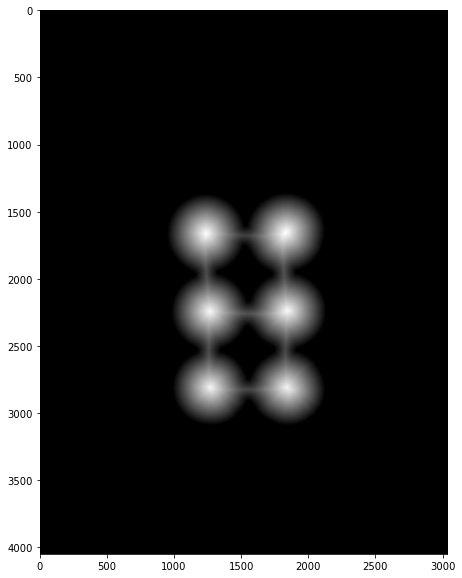

In [84]:
# distance transform
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
display(dist_transform)

* Finding the surely frond ground 

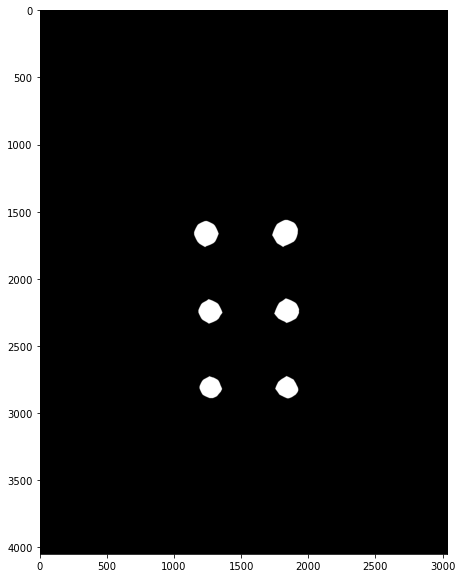

In [85]:
ret,sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
display(sure_fg)

* find unknown region

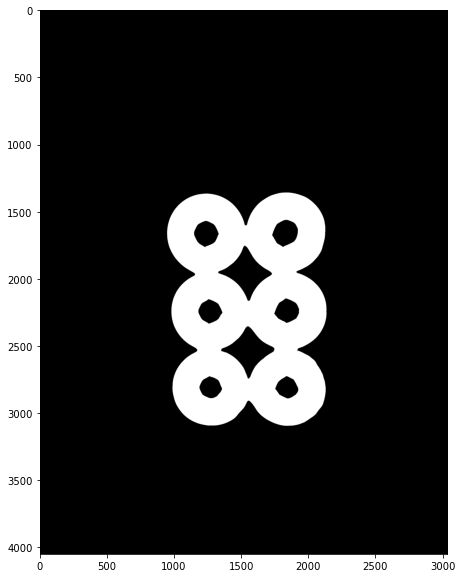

In [86]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
display(unknown)

In [87]:
ret, markers = cv2.connectedComponents(sure_fg)
markers

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

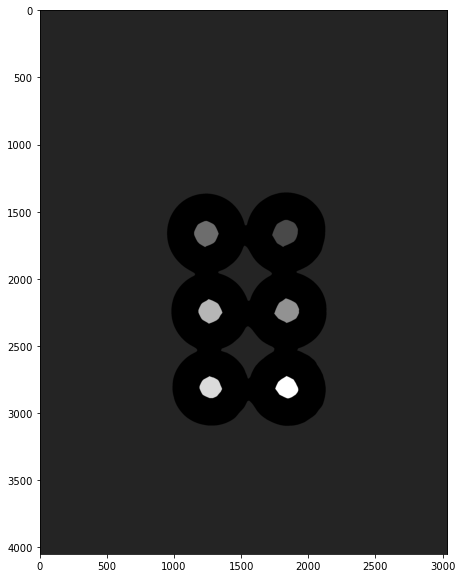

In [88]:
markers = markers + 1
markers[unknown==255] = 0
display(markers)

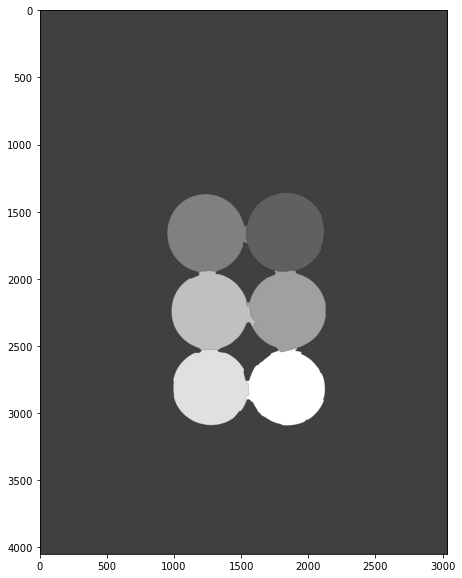

In [89]:
markers = cv2.watershed(img,markers)
display(markers)

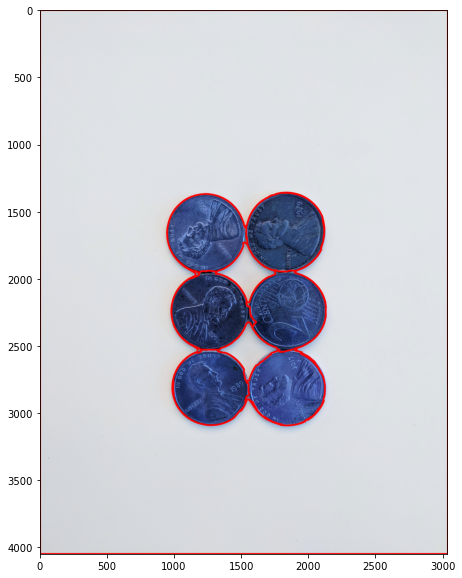

In [90]:
contours,hierarchy = cv2.findContours(markers.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coin,contours,i,(255,0,0),10)
display(sep_coin)

In [91]:
# Clicking watershed
road = cv2.imread('DATA/road_image.jpg')
road_copy = road.copy()
road.shape[:2]

(600, 800)

In [92]:
marker_image = np.zeros(road.shape[:2],dtype=np.int32)
segment = np.zeros(road.shape,dtype = np.uint8)
segment.shape

(600, 800, 3)

In [93]:
from matplotlib import cm
cm.tab10(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

In [94]:
def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3])*255)

In [95]:
colors = []
for i in range(10):
    colors.append(create_rgb(i))
colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

In [96]:
###
####
# COLOR CHOICE
current_marker = 1
#MARKER_UPDATE BY WATERSHED
mark_updates = False
n_markers = 10
#CALLBACK
def mouse_callback(event,x,y,flags,param):
    global mark_updates
    if event == cv2.EVENT_LBUTTONDBLCLK:
        # Marker pass to watershed
        cv2.circle(marker_image,(x,y),10,(current_marker),-1)

        # user see on the road image
        cv2.circle(road_copy,(x,y),10,colors[current_marker],-1)

        mark_updates = True


# Loop
cv2.namedWindow('Road Image')
cv2.setMouseCallback('Road Image',mouse_callback)

while True:
    cv2.imshow('Watershed Segment',segment)
    cv2.imshow('Road Image',road_copy)

    k = cv2.waitKey(1)

    if k == ord('q'):
        break

    # clear all color when press c key
    elif k == ord('c'):
        road_copy = road.copy()
        marker_image = np.zeros(road.shape[:2],dtype=np.int32)
        segment = np.zeros(road.shape,dtype=np.uint8)

    # update color choice
    elif k > 0 and chr(k).isdigit():
        current_marker = int(chr(k))

    #update marking:
    if mark_updates:
        marker_image_copy = marker_image.copy()
        cv2.watershed(road,marker_image_copy)
        segment = np.zeros(road.shape,dtype = np.uint8)

        for color_ind in range(n_markers):
            segment[marker_image_copy==(color_ind)] = colors[color_ind] 
cv2.destroyAllWindows()

### 8 Face Detection with haar cascade

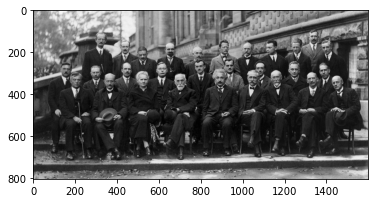

In [97]:
nadia  = cv2.imread('DATA/Nadia_Murad.jpg',0)
denis = cv2.imread('DATA/Denis_Mukwege.jpg',0)
solvay = cv2.imread('DATA/solvay_conference.jpg',0)
plt.imshow(solvay,cmap='gray')

In [98]:
face_cascade = cv2.CascadeClassifier('DATA\haarcascades\haarcascade_frontalface_default.xml')

In [99]:
def detect_face(img):
    face_img = img.copy()

    face_rects = face_cascade.detectMultiScale(face_img)

    for (x,y,h,w) in face_rects:
        cv2.rectangle(face_img,(x,y),(x+w,y+h),(255,255,255),10)

    return face_img

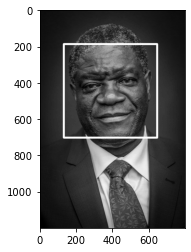

In [100]:
result = detect_face(denis)
plt.imshow(result,cmap='gray')

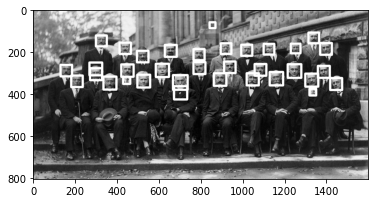

In [101]:
result = detect_face(solvay)
plt.imshow(result,cmap='gray')

In [102]:
def adj_detect_face(img):
    face_img = img.copy()

    face_rects = face_cascade.detectMultiScale(face_img,scaleFactor=1.2,minNeighbors=5)

    for (x,y,h,w) in face_rects:
        cv2.rectangle(face_img,(x,y),(x+w,y+h),(255,255,255),10)

    return face_img

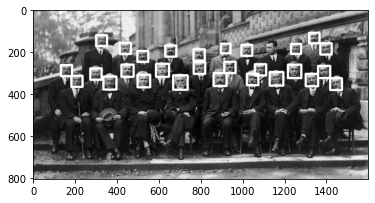

In [103]:
result = adj_detect_face(solvay)
plt.imshow(result,cmap='gray')

In [104]:
eye_cascade = cv2.CascadeClassifier('DATA\haarcascades\haarcascade_eye.xml')

In [105]:
def detect_eyes(img):
    face_img = img.copy()

    eye_rects = eye_cascade.detectMultiScale(face_img)

    for (x,y,h,w) in eye_rects:
        cv2.rectangle(face_img,(x,y),(x+w,y+h),(255,255,255),10)

    return face_img

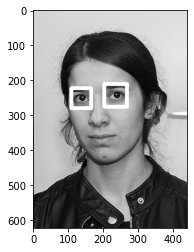

In [106]:
result = detect_eyes(nadia)
plt.imshow(result,cmap='gray')

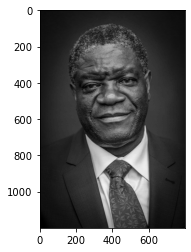

In [107]:
result = detect_eyes(denis)
plt.imshow(result,cmap='gray')

In [108]:
cap = cv2.VideoCapture(0)

while True:
    ret,frame = cap.read(0)

    frame = detect_face(frame)

    cv2.imshow('Video Face Detect',frame)

    k = cv2.waitKey(1)

    if k==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()